<a href="https://colab.research.google.com/github/xxFirefly/CycleGAN/blob/master/myCycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
# for augmentations
!pip install -U albumentations

# for pretrained models for PyTorch
!pip install pretrainedmodels


################
# Catalyst itself
!pip install -U catalyst
# For specific version of catalyst, uncomment:
# ! pip install git+http://github.com/catalyst-team/catalyst.git@{master/commit_hash}
################

# for TTA
# !pip install ttach

# for tensorboard
!pip install tensorflow
%load_ext tensorboard

# for alchemy experiment logging integration, uncomment this 2 lines below
# !pip install -U alchemy
# is_alchemy_used = True

is_fp16_used = False
# if Your machine support Apex FP16, uncomment this 3 lines below
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
# is_fp16_used = True

#!pip install --upgrade efficientnet-pytorch

DEBUG = False

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.4.5)
Requirement already up-to-date: catalyst in /usr/local/lib/python3.6/dist-packages (20.6)


# Includes

In [ ]:
from typing import Callable, List, Tuple 

import os
import torch
import catalyst
import numpy as np

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



torch: 1.5.0+cu101, catalyst: 20.06


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



#**Dataset** 

In [ ]:
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
!unzip -o horse2zebra.zip

--2020-06-21 12:11:42--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘horse2zebra.zip’ not modified on server. Omitting download.

Archive:  horse2zebra.zip
  inflating: horse2zebra/trainA/n02381460_6223.jpg  
  inflating: horse2zebra/trainA/n02381460_1567.jpg  
  inflating: horse2zebra/trainA/n02381460_3354.jpg  
  inflating: horse2zebra/trainA/n02381460_299.jpg  
  inflating: horse2zebra/trainA/n02381460_3001.jpg  
  inflating: horse2zebra/trainA/n02381460_4242.jpg  
  inflating: horse2zebra/trainA/n02381460_1666.jpg  
  inflating: horse2zebra/trainA/n02381460_4396.jpg  
  inflating: horse2zebra/trainA/n02381460_4502.jpg  
  inflating: horse2zebra/trainA/n02381460_8527.jpg  
  inflating: horse2zebra/trainA/n0238

In [ ]:
!ls horse2zebra/

testA  testB  trainA  trainB


In [ ]:
from pathlib import Path

ROOT = "horse2zebra"
ALL_IMAGES = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
A_IMGS = list(filter(lambda x: x.parent.name.startswith('trainA'), ALL_IMAGES)) 
B_IMGS = list(filter(lambda x: x.parent.name.startswith('trainB'), ALL_IMAGES)) 
A_IMGS_TEST = list(filter(lambda x: x.parent.name.startswith('testA'), ALL_IMAGES)) 
B_IMGS_TEST = list(filter(lambda x: x.parent.name.startswith('testB'), ALL_IMAGES)) 
print("Train: Number of horses: {}; Number of zebras: {}".format(len(A_IMGS), len(B_IMGS)))
print("Test:  Number of horses: {}; Number of zebras: {}".format(len(A_IMGS_TEST), len(B_IMGS_TEST)))

Train: Number of horses: 1067; Number of zebras: 1334
Test:  Number of horses: 120; Number of zebras: 140


In [ ]:
from typing import List

from torch.utils.data import Dataset


class GanDataset(Dataset):
    def __init__(
        self,
        A_images: List[Path],
        B_images: List[Path],
        transforms=None
    ) -> None:
        self.A_images = A_images
        self.B_images = B_images
        self.transforms = transforms

    def __len__(self) -> int:
        if ( len(self.A_images) <  len(self.B_images)):
          return len(self.A_images)
        return len(self.B_images)
        
    def __getitem__(self, idx: int) -> dict:
        A_image_path = self.A_images[idx]
        A_image = utils.imread(A_image_path)
        
        B_image_path = self.B_images[idx]
        B_image = utils.imread(B_image_path)
        

        result = {"image": A_image, "B_image": B_image}
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["A_filename"] = A_image_path.name
        result["B_filename"] = B_image_path.name


        return result

#**UTILS**

In [ ]:
from catalyst.utils import imread
import numpy as np

import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

In [ ]:
if (DEBUG):
  images = read_random_images(ALL_IMAGES)
  show_examples(images)

**TRANSFORMS NEW -- NEED TO DO**

In [ ]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ], additional_targets={"B_image" : "image"})
    return result

In [ ]:
train_transforms = compose([
    resize_transforms(), 
#    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([resize_transforms(), hard_transforms()])

/usr/local/lib/python3.6/dist-packages/albumentations/pytorch/transforms.py:59: DeprecationWarning:

ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:1471: DeprecationWarning:

This class has been deprecated. Please use CoarseDropout



In [ ]:
if (DEBUG):
  images = read_random_images(ALL_IMAGES)

  images = [
      (title, show_transforms(image=i)["image"])
      for (title, i) in images
  ]
  show_examples(images)

## Loaders

In [ ]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    A_images: List[Path],
    B_images: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    if (len(A_images) < len(B_images)):
      indices = np.arange(len(A_images))
    else:
      indices = np.arange(len(B_images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_A_images = np.array(A_images)
    np_B_images = np.array(B_images)

    # Creates our train dataset
    train_dataset = GanDataset(
      A_images = np_A_images[train_indices].tolist(),
      B_images = np_B_images[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = GanDataset(
      A_images = np_A_images[valid_indices].tolist(),
      B_images = np_B_images[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [ ]:
if is_fp16_used:
    batch_size = 64
else:
    batch_size = 32

batch_size = 1
print(f"batch_size: {batch_size}")

loaders = get_loaders(
    A_images=A_IMGS,
    B_images=B_IMGS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

batch_size: 1


In [ ]:
#next(iter(loaders['train']))

# Models

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
# discriminator model
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)


class SimpleGenerator(nn.Module):
    """Generator for transfering from svhn to mnist"""
    def __init__(self, conv_dim=64):
        super(SimpleGenerator, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, bn=False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = F.tanh(self.deconv2(out))            # (?, 1, 32, 32)
        return out

class SimpleDiscriminator(nn.Module):
    """Discriminator for svhn."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(SimpleDiscriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.fc = conv(conv_dim*4, 1, 4, 1, 0)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        #out = F.leaky_relu(self.conv4(out), 0.05)  # (?, 256, 4, 4)
        #out = out.squeeze().flatten(start_dim=1)
        out = self.fc(out)
        return out


class D2(nn.Module):
    """Discriminator for svhn."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D2, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

#0: torch.Size([64, 3, 224, 224])
#1: torch.Size([64, 64, 112, 112])
#2: torch.Size([64, 128, 56, 56])
#3: torch.Size([64, 256, 28, 28])
#4: torch.Size([64, 1, 25, 25])



In [ ]:
def encode(in_chs, out_chs=False, kernel=3, pad=1):
  if(not out_chs):
    out_chs = in_chs

  layer = nn.Sequential(
            nn.Conv2d(in_channels=in_chs, out_channels=out_chs, kernel_size=kernel, padding=pad),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
  return layer

def decode(in_chs, out_chs=False, activation=True):
    if(not out_chs):
      out_chs = in_chs

    layer = nn.Sequential(
              nn.UpsamplingBilinear2d(scale_factor=2),
              nn.Conv2d(in_channels=in_chs, out_channels=out_chs, kernel_size=3, padding=1)
          )

    if (activation):
      layer = nn.Sequential(*layer,nn.BatchNorm2d(out_chs))
      layer = nn.Sequential(*layer, nn.ReLU())
    return layer

class Block(nn.Module): 
    # based on resnet
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()

        self.shortcut  = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          self.shortcut  = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels))

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.block(x)
        out += self.shortcut(x)
        out = F.relu(out)

        return out


class Generator(nn.Module):
    def __init__(self, chs=128):
        super().__init__()
        self.enc_conv0 = encode(3, 32) # 256 -> 128
        self.enc_conv1 = encode(32, 64) # 128 -> 64

        self.conv1 = Block(64, chs) # 64
        self.conv2 = Block(chs, chs) # 64
        self.conv3 = Block(chs, chs) # 64
        self.conv4 = Block(chs, chs) # 64
        self.conv5 = Block(chs, chs) # 64
        self.conv6 = Block(chs, chs) # 64
        
        self.dec_conv0 = decode(chs, 32) # 64 -> 128
        self.dec_conv1 = decode(32, 3, activation=False) # 128 -> 256

        
    def forward(self, x):
      e1 = self.enc_conv0(x)
      e2 = self.enc_conv1(e1)
      
      b = self.conv1(e2)
      b = self.conv2(b)
      b = self.conv3(b)
      b = self.conv4(b)
      b = self.conv5(b)
      b = self.conv6(b)
      
      d = self.dec_conv0(b)
      d = self.dec_conv1(d)
      return d
      


In [ ]:
G_AB = Generator()
G_BA = Generator()
D_A = D2()
D_B = D2()
lr = 2e-4
model = {"g_AB": G_AB, "d_A": D_A, "g_BA": G_BA, "d_B": D_B}

g_params = list(G_AB.parameters()) + list(G_BA.parameters())
#d_params = list() + list(D_B.parameters())
        
optimizer = {
    "g_AB": torch.optim.Adam(G_AB.parameters(), lr=lr, betas=(0.5, 0.999)),
    "g_BA": torch.optim.Adam(G_BA.parameters(), lr=lr, betas=(0.5, 0.999)),
    "d_A": torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999)),
    "d_B": torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999)),
}


In [ ]:
dummy = torch.ones(1, 3, 256, 256)*0.5
pred = D_A(dummy)
torch.mean(pred.detach())

tensor(0.0105)

In [ ]:
from catalyst import dl
from catalyst.utils import metrics

class GANRunner(dl.Runner):
  
  def __init__(
    self, 
    model = None, 
    device = None,  
  ):
    super().__init__(model, device)

  def predict_batch(self, batch):
    A_images = batch["image"].to(self.device)
    generated_images = self.model["g_AB"](A_images)
    return generated_images

  def predict_simple_batch(self, batch):
    A_images = batch.to(self.device)
    generated_images = self.model["g_AB"](A_images)
    return generated_images

  def optimize_discriminator(self, opt_name, A_images, B_images, model_G, model_D, batch_metrics):
    #process real images
    A_predictions = model_D(A_images)
    d_A_real_loss = \
      torch.mean((A_predictions - 1)**2)

    # process fake images
    fake_A_images = model_G(B_images)
    fake_A_predictions = model_D(fake_A_images.detach())
    d_A_fake_loss = \
      torch.mean((fake_A_predictions)**2)
    
    d_loss_A = (d_A_real_loss + d_A_fake_loss)/2.
    
    metric_name = opt_name + '_loss'
    batch_metrics[metric_name] = d_loss_A


  def optimize_generators(self, A_images, B_images, batch_metrics, LAMBDA=10):
    # Train the A-B-A cycle
    fake_B_images = self.model["g_AB"](A_images)
    fake_B_predictions = self.model["d_B"](fake_B_images) #.detach
    reconst_A_images = self.model["g_BA"](fake_B_images)
    
    #g_loss_ABA = torch.mean((fake_B_predictions - 1)**2) \
    #  + torch.mean(torch.abs(A_images - reconst_A_images))
    g_ABA_loss_cycle = torch.mean(torch.abs(A_images - reconst_A_images))
    g_ABA_loss_pred =  torch.mean((fake_B_predictions - 1)**2)
    g_AB_loss =  g_ABA_loss_cycle*LAMBDA + g_ABA_loss_pred
    
    batch_metrics['g_ABA_loss_cycle'] = g_ABA_loss_cycle
    batch_metrics['g_AB_loss'] = g_AB_loss

    """if self.is_train_loader:
        g_loss.backward()
        self.optimizer['g'].step()
        self.optimizer['g'].zero_grad()
    """
    # Train the B-A-B cycle
    fake_A_images = self.model["g_BA"](B_images)
    fake_A_predictions = self.model["d_A"](fake_A_images) #.detach
    reconst_B_images = self.model["g_AB"](fake_A_images)
    
    #  + torch.mean(torch.abs(A_images - reconst_A_images))
    g_BAB_loss_cycle = torch.mean(torch.abs(B_images - reconst_B_images))
    g_BAB_loss_pred =  torch.mean((fake_A_predictions - 1)**2)
    g_BA_loss =  g_BAB_loss_cycle*LAMBDA + g_BAB_loss_pred
    
    batch_metrics['g_BAB_loss_cycle'] = g_BAB_loss_cycle
    batch_metrics['g_BA_loss'] = g_BA_loss

    g_loss = g_AB_loss + g_BA_loss

    batch_metrics['g_loss'] = g_loss
  
  def _handle_batch(self, batch):
    A_images = batch["image"]
    B_images = batch["B_image"]
    batch_metrics = {}
        
    #self.optimizer['g'].zero_grad()
    #self.optimizer['d_A'].zero_grad()
    #self.optimizer['d_B'].zero_grad()

    #############################
    # GENERATORS TRAINING
    #############################

    self.optimize_generators(
        A_images=A_images, B_images=B_images,
        batch_metrics=batch_metrics)    

    #############################
    # DISCRIMINATORS TRAINING
    #############################

    # Train the discriminators
    self.optimize_discriminator(
        opt_name='d_B', A_images=A_images, B_images=B_images, 
        model_G=self.model["g_AB"], model_D=self.model["d_B"],
        batch_metrics=batch_metrics)
    
    self.optimize_discriminator(
        opt_name='d_A', A_images=A_images, B_images=B_images, 
        model_G=self.model["g_BA"], model_D=self.model["d_A"],
        batch_metrics=batch_metrics)   

    self.batch_metrics.update(**batch_metrics)
    


In [ ]:
logdir = "./logs_gan"
runner = GANRunner()
runner.train(
    model=model,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=[
    dl.OptimizerCallback(
        optimizer_key="g_AB", 
        metric_key="g_AB_loss"
    ),
    dl.OptimizerCallback(
        optimizer_key="g_BA", 
        metric_key="g_BA_loss"
    ),
    dl.OptimizerCallback(
        optimizer_key="d_A", 
        metric_key="d_A_loss"
    ),
    dl.OptimizerCallback(
        optimizer_key="d_B", 
        metric_key="d_B_loss"
    ),
    ],
    main_metric="g_loss",
    
    num_epochs=100,
    check=False,
    verbose=True,
    logdir=logdir,
)










1/100 * Epoch (train):   0% 0/853 [00:00<?, ?it/s]

RuntimeError: ignored

# Model **predictions**


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils


def show_examples(name: str, image: np.ndarray, generated: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(generated)
    plt.title(f"Generated: {name}")

In [ ]:
num_workers: int = 4

# Creates our valid dataset
np_A_images = A_IMGS_TEST;
np_B_images = B_IMGS_TEST;

test_dataset = GanDataset(
  A_images = np_A_images,
  B_images = np_B_images,
  transforms = valid_transforms
)

# Catalyst uses normal torch.data.DataLoader
infer_loader = DataLoader(
  test_dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=num_workers,
  drop_last=True,
)

iter_dataset = iter(infer_loader)
iter_generated = iter(runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/best.pth"))

#print(image.shape, gen_image.shape)
#print(type(image), type(gen_image))

In [ ]:
images = next(iter_dataset)['image']
gen_images = runner.model['g_AB'](images.cuda())
i = 0




(224, 224, 3) (224, 224, 3)
Discriptor pred: of real images: 0.96
Discriptor pred of fake images: -0.40


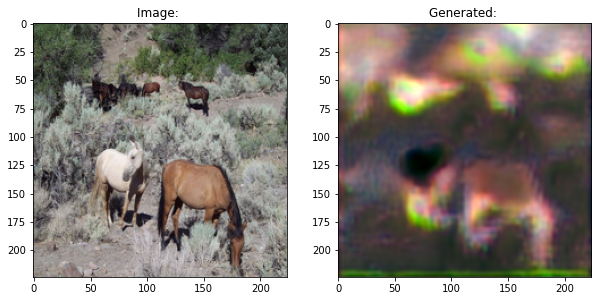

In [ ]:
image = utils.tensor_to_ndimage(images[i])
gen_image = gen_images[i].cpu().detach()
gen_image = utils.tensor_to_ndimage(gen_image)
print(image.shape, gen_image.shape)

test_D_A = runner.model['d_A'](images.cuda())
#test_D_B = runner.model['d_B'](images.cuda())
print("Discriptor pred: of real images: {:.2f}".format(torch.mean(test_D_A)))
print("Discriptor pred of fake images: {:.2f}".format(torch.mean(gen_images)))

show_examples(name="", image=image, generated=gen_image)
i += 1